# NICE for calibration: Comparison against Temperature Scaling 

In [1]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

from utils.data import get_cifar10, get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary
from calibrators import NiceCalibrator, TempScalingCalibrator

In [2]:
%matplotlib inline
np.random.seed(1)

In [3]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

## CNN trained on CIFAR3

Load dataset and precomputed logits:

In [4]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

### Evaluating misscalibration of the base model

Negative log-likelihood of the uncalibrated model on the validation set: 0.307
Expected calibration error of the uncalibrated model on the validation set: 0.02323


Negative log-likelihood of the uncalibrated model on the test set: 0.339
Expected calibration error of the uncalibrated model on the test set: 0.02812


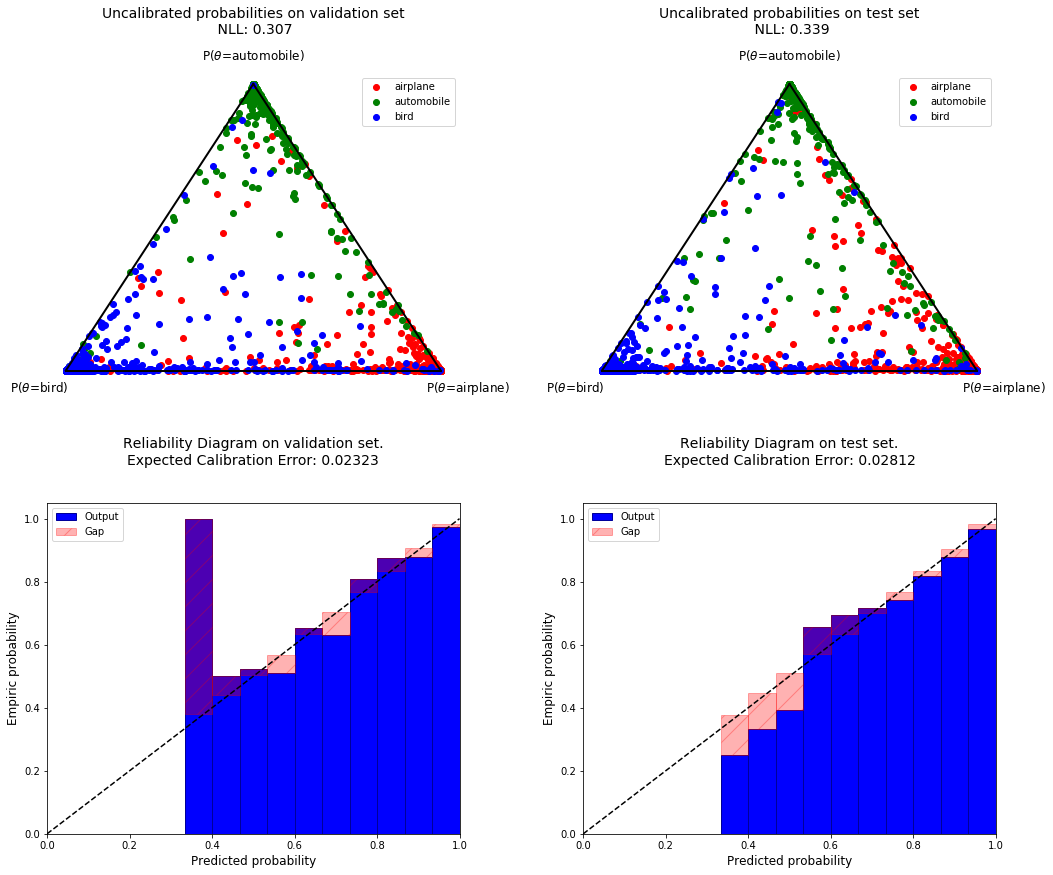

In [5]:
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)

# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the validation set: {:.3f}'.format(val_nll))
print('Expected calibration error of the uncalibrated model on the validation set: {:.5f}'.format(val_ece))

print('\n')

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)

print('Negative log-likelihood of the uncalibrated model on the test set: {:.3f}'.format(test_nll))
print('Expected calibration error of the uncalibrated model on the test set: {:.5f}'.format(test_ece))

fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Uncalibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)

plt.show()

### Estimated PDF for different classes:

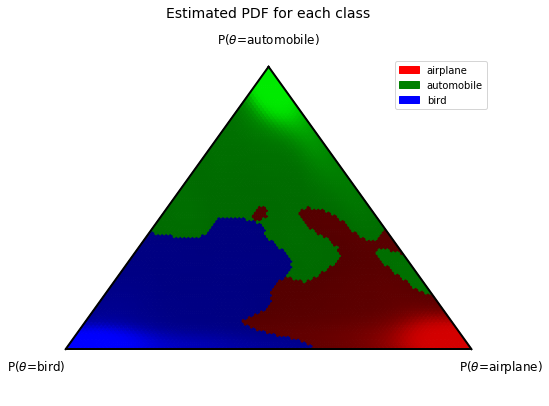

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

ax = plot_pdf_simplex(probs, target=target, ax=ax, scale=100, title='Estimated PDF for each class',
                      fontsize=12, labels=list(ix2label.values()));
plt.show()

### Calibrating with Temp-Scaling:

In [7]:
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}".format(temp_scaling_cal.T))

Calibrated using temperature T=1.107


Negative log-likelihood on the validation set after temp-scaling calibration: 0.305
Expected calibration error on the validation set after temp-scaling calibration: 0.02306


Negative log-likelihood on the test set after temp-scaling calibration: 0.336
Expected calibration error on the test set after temp-scaling calibration: 0.02140


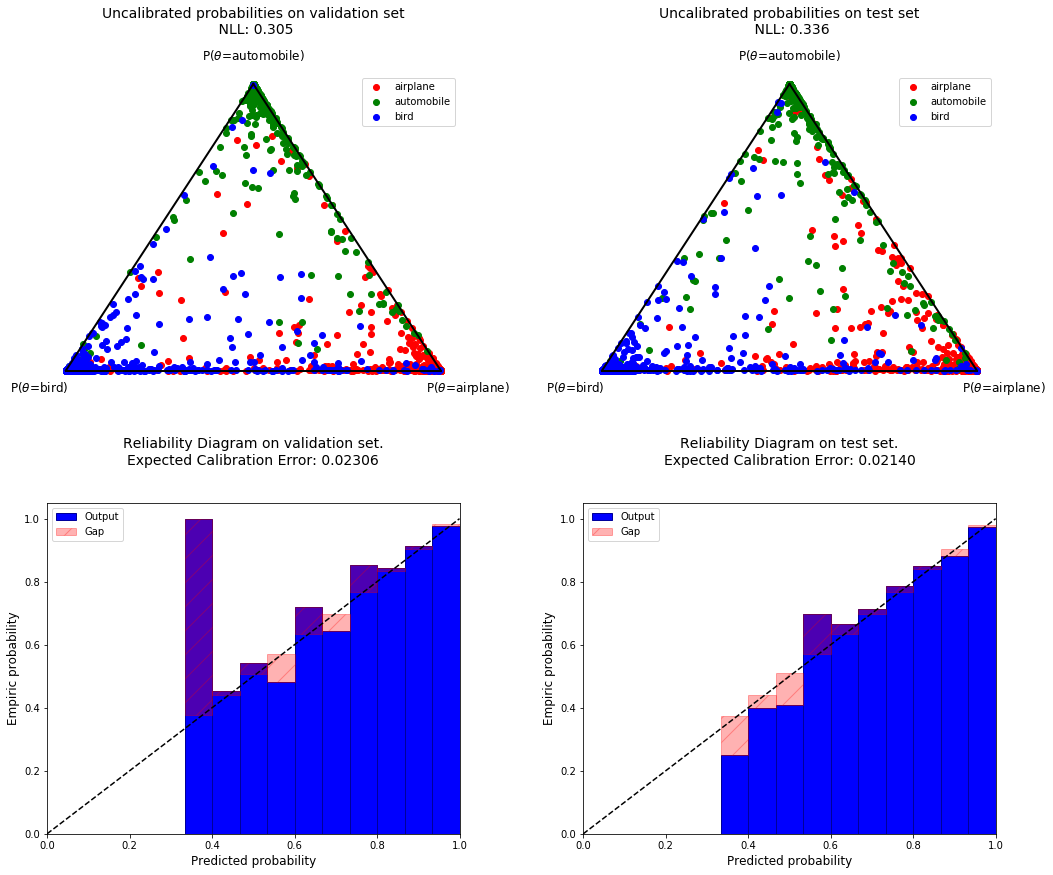

In [8]:
val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)

# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

print('Negative log-likelihood on the validation set after temp-scaling calibration: {:.3f}'.format(val_nll_temp))
print('Expected calibration error on the validation set after temp-scaling calibration: {:.5f}'.format(val_ece_temp))

print('\n')

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)

print('Negative log-likelihood on the test set after temp-scaling calibration: {:.3f}'.format(test_nll_temp))
print('Expected calibration error on the test set after temp-scaling calibration: {:.5f}'.format(test_ece_temp))

fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll_temp),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Uncalibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll_temp),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)
plt.show()

### Calibrating using NICE flow:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Fitted in 692.922s


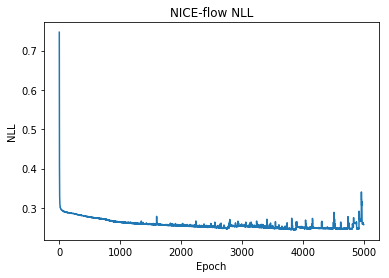

In [9]:
t0 = time.time()
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[4, 4],
                          version=2, epochs=5000, batch_size=50)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

Negative log-likelihood on the validation set after NICE calibration: 0.257
Expected calibration error on the validation set after NICE calibration: 0.01212


Negative log-likelihood on the test set after NICE calibration: 0.492
Expected calibration error on the test set after NICE calibration: 0.03829


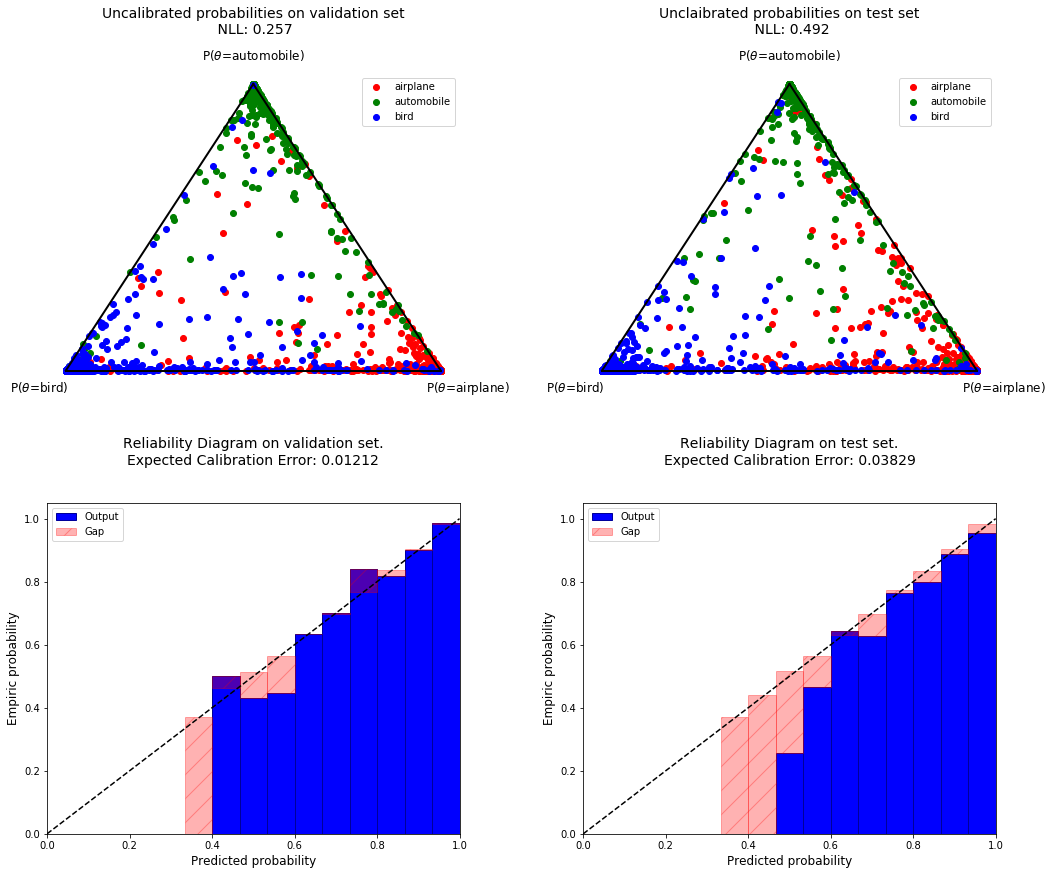

In [10]:
val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

print('Negative log-likelihood on the validation set after NICE calibration: {:.3f}'.format(val_nll_nice))
print('Expected calibration error on the validation set after NICE calibration: {:.5f}'.format(val_ece_nice))

print('\n')

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

print('Negative log-likelihood on the test set after NICE calibration: {:.3f}'.format(test_nll_nice))
print('Expected calibration error on the test set after NICE calibration: {:.5f}'.format(test_ece_nice))


fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
ax_arr[0, 0] = plot_prob_simplex(val_probs, target=val_target, ax=ax_arr[0, 0],
                                 title='Uncalibrated probabilities on validation set\n NLL: {:.3f}'.format(val_nll_nice),
                                 fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_prob_simplex(test_probs, target=test_target, ax=ax_arr[0, 1],
                                 title='Unclaibrated probabilities on test set\n NLL: {:.3f}'.format(test_nll_nice),
                                 fontsize=12, labels=list(ix2label.values()));

ax_arr[1, 0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[1, 0], title='Reliability Diagram on validation set.'+
                                '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[1, 1], title='Reliability Diagram on test set.' + 
                                '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)
plt.show()

### Calibration comparison:

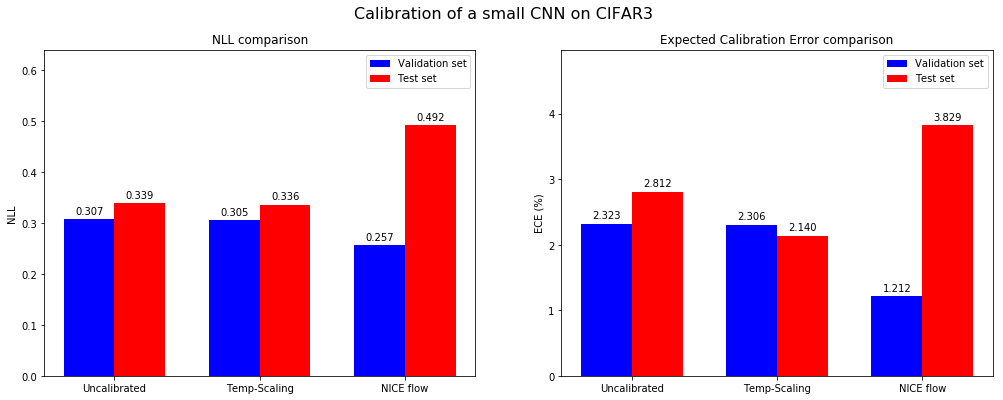

In [11]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))
fig.suptitle('Calibration of a small CNN on CIFAR3', fontsize=16)


ind = np.arange(3)
width = 0.35

ticks = ['Uncalibrated', 'Temp-Scaling', 'NICE flow']


validation = np.array([val_nll, val_nll_temp, val_nll_nice])
test = np.array([test_nll, test_nll_temp, test_nll_nice])

def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height.
    Taken from:
    'https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py'
    
    """
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.3f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')



rects1 = ax_arr[0].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[0].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_title('NLL comparison')
ax_arr[0].set_xticks(ind + width / 2)
ax_arr[0].set_xticklabels(ticks)
ax_arr[0].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[0].legend()

autolabel(rects1, ax_arr[0])
autolabel(rects2, ax_arr[0])


validation = np.array([val_ece, val_ece_temp, val_ece_nice])*100
test = np.array([test_ece, test_ece_temp, test_ece_nice])*100

rects1 = ax_arr[1].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[1].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[1].set_ylabel('ECE (%)')
ax_arr[1].set_title('Expected Calibration Error comparison')
ax_arr[1].set_xticks(ind + width / 2)
ax_arr[1].set_xticklabels(ticks)
ax_arr[1].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[1].legend()

autolabel(rects1, ax_arr[1])
autolabel(rects2, ax_arr[1])

plt.show()

### Visualize decision regions on the simplex:

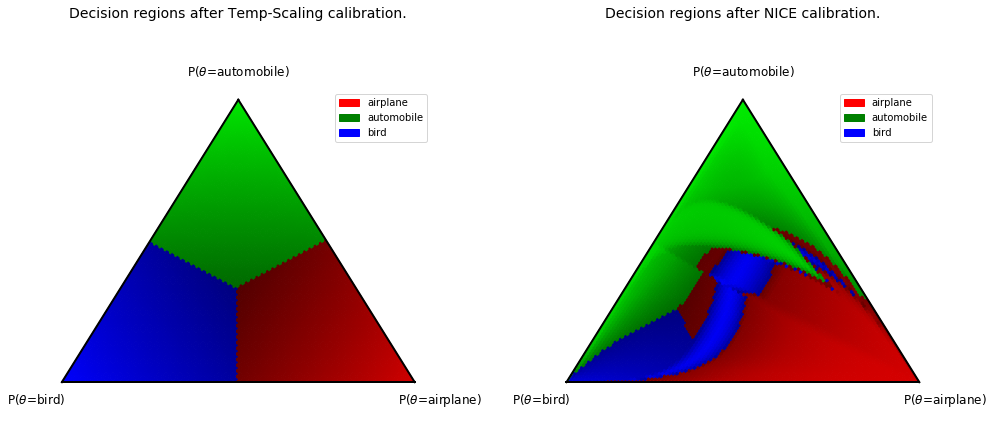

In [12]:
### Create plot
fig, ax_arr = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

ax_arr[0] = plot_cal_regions_ternary(temp_scaling_cal, ax=ax_arr[0], scale=100, labels=list(ix2label.values()),
                                     title='Decision regions after Temp-Scaling calibration.\n\n', fontsize=12);
ax_arr[1] = plot_cal_regions_ternary(nice_cal, ax=ax_arr[1], scale=100, labels=list(ix2label.values()),
                                     title='Decision regions after NICE calibration.\n\n', fontsize=12);

plt.show();

### Samples spoiling NLL on the test set:

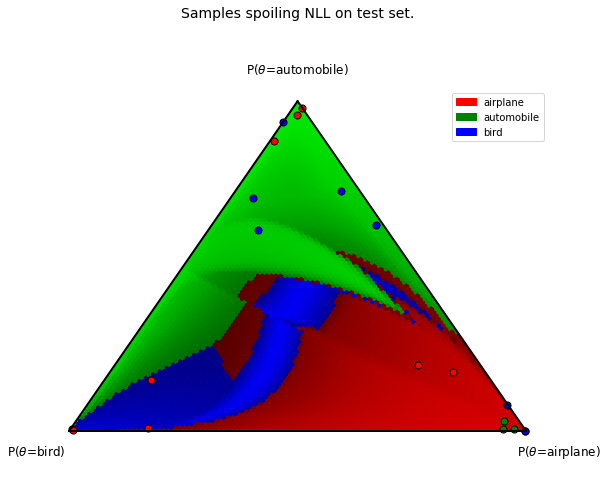

In [13]:
indv_nll = -np.sum(test_target*np.log(test_probs_nice+1e-7), axis=1)
spoiling_idx = np.argsort(indv_nll)[:-21:-1]
spoiling_probs = test_probs[spoiling_idx, :]
spoiling_target = np.argmax(test_target[spoiling_idx, :], axis=1)

fig, ax = plt.subplots(figsize=(9, 7))

ax = plot_cal_regions_ternary(nice_cal, ax=ax, scale=100, labels=list(ix2label.values()),
                                     title='Samples spoiling NLL on test set.\n\n', fontsize=12);
ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)

plt.show();

## Analysis on CIFAR10

In [14]:
cifar10, ix2label = get_cifar10(cifar_dir, test=True)

target = onehot_encode(cifar10['test_labels'])

# val/test split
random_split = np.random.permutation(10000)

val_target = target[random_split[:5000], :]
test_target = target[random_split[5000:], :]

### Load precomputed logits

In [15]:
model = 'resnet32_v1'

In [16]:
_, logits = load_logits(os.path.join(models_dir, model))

# val/test split
val_logits = logits[random_split[:5000], :]
test_logits = logits[random_split[5000:], :]

### Calibrate the model

Calibrated using temperature T=1.774




C:\Users\sergi\Anaconda3\envs\famarch\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


NICE flow fitted in 671.319s


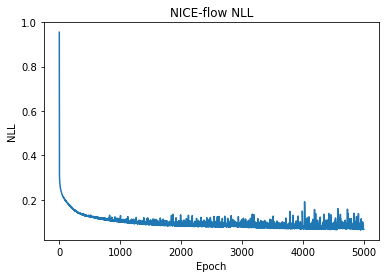

In [17]:
### Uncalibrated model
val_probs = softmax(val_logits, axis=1)
test_probs = softmax(test_logits, axis=1)


### Temp-Scaling
temp_scaling_cal = TempScalingCalibrator(val_logits, val_target)
print("Calibrated using temperature T={:.3f}\n\n".format(temp_scaling_cal.T))

val_probs_temp = temp_scaling_cal.predict(val_logits)
test_probs_temp = temp_scaling_cal.predict(test_logits)


### NICE-flow
t0 = time.time()
nice_cal = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=[10, 10], epochs=5000)
print('NICE flow fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
plt.plot(nice_cal.history.history['loss'])
plt.title('NICE-flow NLL')
plt.ylabel('NLL')
plt.xlabel('Epoch')
plt.show()

val_probs_nice = nice_cal.predict(val_logits)
test_probs_nice = nice_cal.predict(test_logits)

### Evaluate performance

In [18]:
## Uncalibrated model
# Validation set
val_nll = neg_log_likelihood(val_probs, val_target)
val_ece = expected_calibration_error(val_probs, val_target, bins=15)

# Test set
test_nll = neg_log_likelihood(test_probs, test_target)
test_ece = expected_calibration_error(test_probs, test_target, bins=15)


## Temp-Scaling
# Validation set
val_nll_temp = neg_log_likelihood(val_probs_temp, val_target)
val_ece_temp = expected_calibration_error(val_probs_temp, val_target, bins=15)

# Test set
test_nll_temp = neg_log_likelihood(test_probs_temp, test_target)
test_ece_temp = expected_calibration_error(test_probs_temp, test_target, bins=15)


## Nice-flow
# Validation set
val_nll_nice = neg_log_likelihood(val_probs_nice, val_target)
val_ece_nice = expected_calibration_error(val_probs_nice, val_target, bins=15)

# Test set
test_nll_nice = neg_log_likelihood(test_probs_nice, test_target)
test_ece_nice = expected_calibration_error(test_probs_nice, test_target, bins=15)

### Calibration comparison:

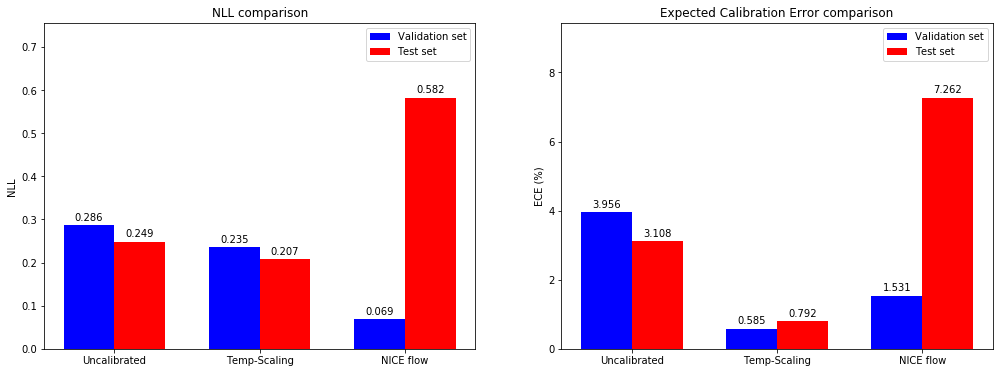

In [19]:
fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))

ind = np.arange(3)
width = 0.35

ticks = ['Uncalibrated', 'Temp-Scaling', 'NICE flow']


validation = np.array([val_nll, val_nll_temp, val_nll_nice])
test = np.array([test_nll, test_nll_temp, test_nll_nice])

rects1 = ax_arr[0].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[0].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[0].set_ylabel('NLL')
ax_arr[0].set_title('NLL comparison')
ax_arr[0].set_xticks(ind + width / 2)
ax_arr[0].set_xticklabels(ticks)
ax_arr[0].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[0].legend()

autolabel(rects1, ax_arr[0])
autolabel(rects2, ax_arr[0])


validation = np.array([val_ece, val_ece_temp, val_ece_nice])*100
test = np.array([test_ece, test_ece_temp, test_ece_nice])*100

rects1 = ax_arr[1].bar(ind, validation, width, color='b', label='Validation set')
rects2 = ax_arr[1].bar(ind+width, test, width, color='r', label='Test set')

ax_arr[1].set_ylabel('ECE (%)')
ax_arr[1].set_title('Expected Calibration Error comparison')
ax_arr[1].set_xticks(ind + width / 2)
ax_arr[1].set_xticklabels(ticks)
ax_arr[1].set_ylim([0, max(validation.max(), test.max())*1.3])
ax_arr[1].legend()

autolabel(rects1, ax_arr[1])
autolabel(rects2, ax_arr[1])

plt.show()

### Reliability diagrams

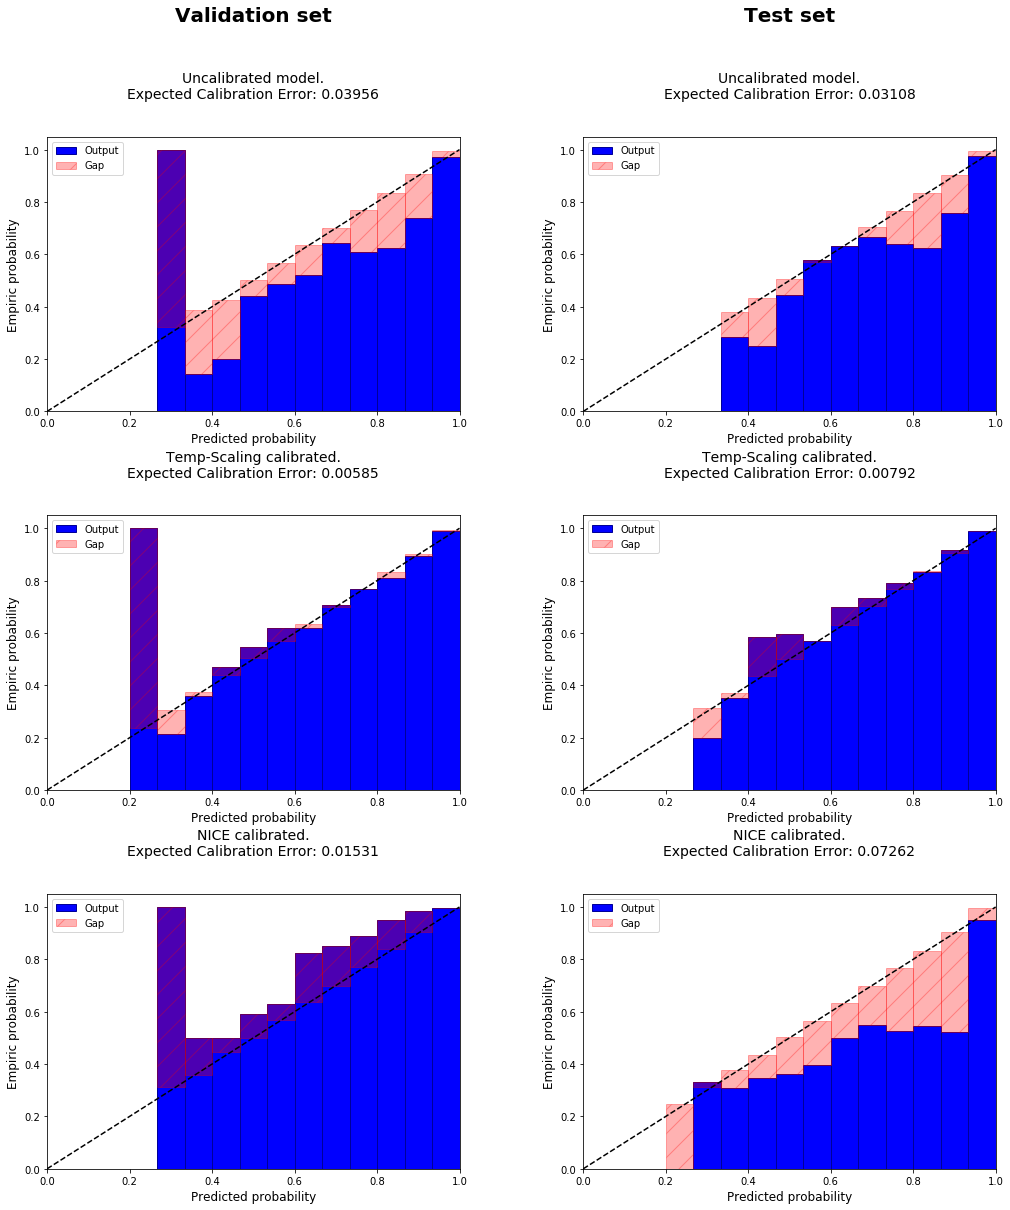

In [27]:
fig, ax_arr = plt.subplots(4, 2, figsize=(17, 21), gridspec_kw={'hspace': 0.5, 'wspace': 0.3, "height_ratios":[0.02,1,1,1]})

ax_arr[0, 0].axis("off")
ax_arr[0, 0].set_title('Validation set', fontweight='bold', fontsize=20)

ax_arr[0, 1].axis("off")
ax_arr[0, 1].set_title('Test set', fontweight='bold', fontsize=20)

ax_arr[1, 0] = reliability_diagram(val_probs, val_target, ax=ax_arr[1, 0], title='Uncalibrated model.'+
                                   '\nExpected Calibration Error: {:.5f}'.format(val_ece), bins=15)
ax_arr[1, 1] = reliability_diagram(test_probs, test_target, ax=ax_arr[1, 1], title='Uncalibrated model.' + 
                                   '\nExpected Calibration Error: {:.5f}'.format(test_ece), bins=15)

ax_arr[2, 0] = reliability_diagram(val_probs_temp, val_target, ax=ax_arr[2, 0], title='Temp-Scaling calibrated.'+
                                   '\nExpected Calibration Error: {:.5f}'.format(val_ece_temp), bins=15)
ax_arr[2, 1] = reliability_diagram(test_probs_temp, test_target, ax=ax_arr[2, 1], title='Temp-Scaling calibrated.' + 
                                   '\nExpected Calibration Error: {:.5f}'.format(test_ece_temp), bins=15)

ax_arr[3, 0] = reliability_diagram(val_probs_nice, val_target, ax=ax_arr[3, 0], title='NICE calibrated.'+
                                   '\nExpected Calibration Error: {:.5f}'.format(val_ece_nice), bins=15)
ax_arr[3, 1] = reliability_diagram(test_probs_nice, test_target, ax=ax_arr[3, 1], title='NICE calibrated.' + 
                                   '\nExpected Calibration Error: {:.5f}'.format(test_ece_nice), bins=15)
plt.show()

### Analysis of NLL:

Take a look at why NLL increase so much in the test set after calibrating on validation set. We inspect the individual contribution of each sample to the average NLL.

#### Distribution of individual contributions for the uncalibrated model:

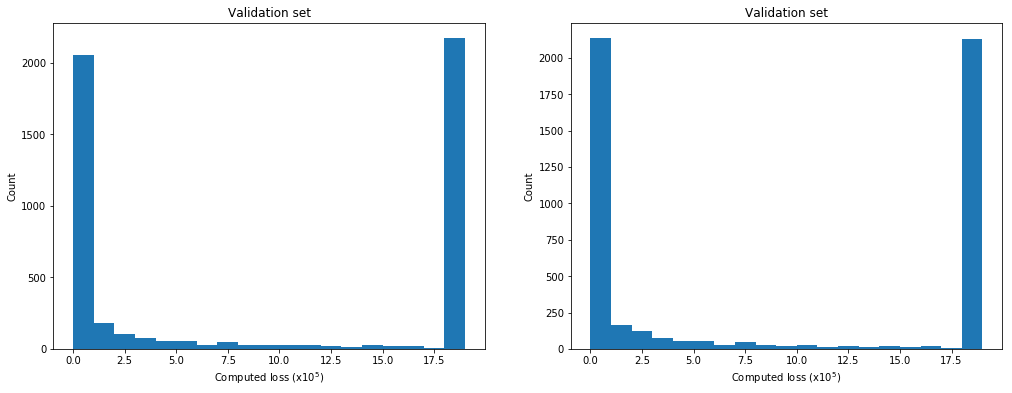

In [21]:
val_losses = -np.sum(val_target*np.log(val_probs+1e-7), axis=1)*1e5
test_losses = -np.sum(test_target*np.log(test_probs+1e-7), axis=1)*1e5

fig, ax_arr = plt.subplots(1, 2, figsize=(17, 6))

bins = np.arange(20)

ax_arr[0].hist(np.clip(val_losses, bins[0], bins[-1]), bins=bins);
ax_arr[0].set_title('Validation set')
ax_arr[0].set_ylabel('Count')
ax_arr[0].set_xlabel('Computed loss (x$10^5$)')

ax_arr[1].hist(np.clip(test_losses, bins[0], bins[-1]), bins=bins);
ax_arr[1].set_title('Validation set')
ax_arr[1].set_ylabel('Count')
ax_arr[1].set_xlabel('Computed loss (x$10^5$)')

plt.show()

#### Distribution of individual contributions after calibration:

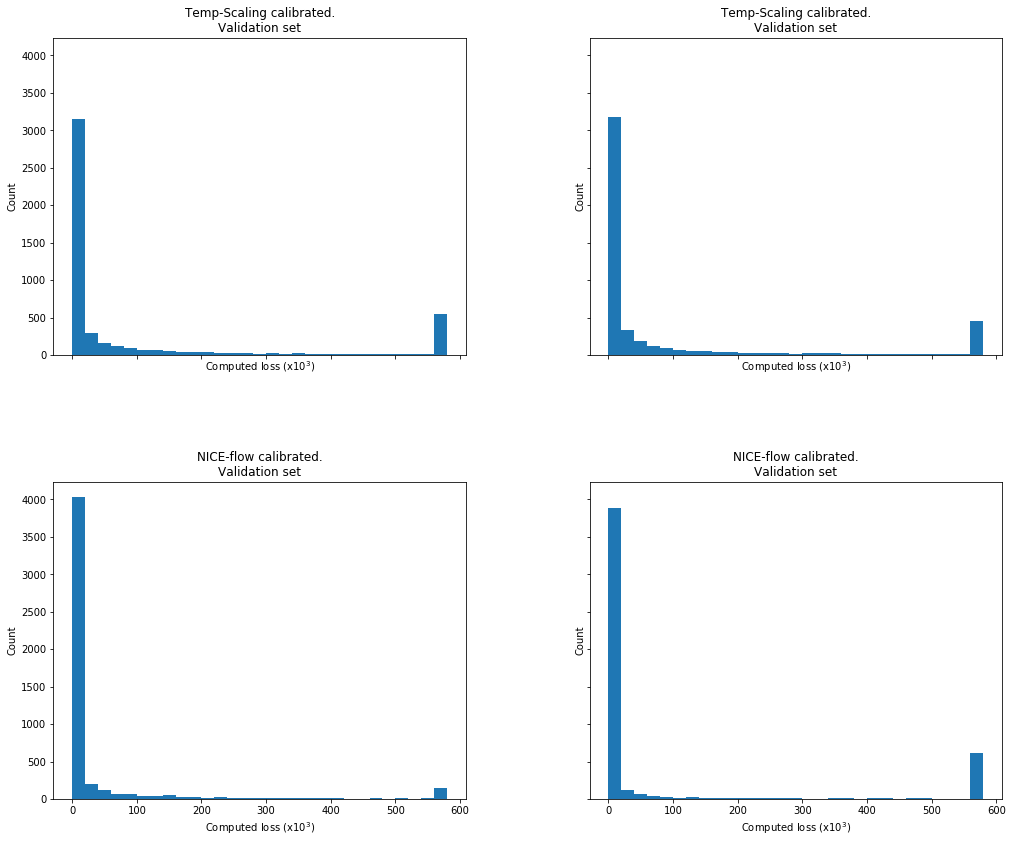

In [22]:
exp = 3

val_losses_temp = -np.sum(val_target*np.log(val_probs_temp+1e-7), axis=1)*(10**exp)
test_losses_temp = -np.sum(test_target*np.log(test_probs_temp+1e-7), axis=1)*(10**exp)

val_losses_nice = -np.sum(val_target*np.log(val_probs_nice+1e-7), axis=1)*(10**exp)
test_losses_nice = -np.sum(test_target*np.log(test_probs_nice+1e-7), axis=1)*(10**exp)

fig, ax_arr = plt.subplots(2, 2, figsize=(17, 14), gridspec_kw={'hspace': 0.4, 'wspace': 0.3}, sharex=True, sharey=True)

bins = np.arange(30)*20

ax_arr[0, 0].hist(np.clip(val_losses_temp, bins[0], bins[-1]), bins=bins)
ax_arr[0, 0].set_title('Temp-Scaling calibrated.\nValidation set')
ax_arr[0, 0].set_ylabel('Count')
ax_arr[0, 0].set_xlabel('Computed loss (x$10^{}$)'.format(exp))

ax_arr[0, 1].hist(np.clip(test_losses_temp, bins[0], bins[-1]), bins=bins)
ax_arr[0, 1].set_title('Temp-Scaling calibrated.\nValidation set')
ax_arr[0, 1].set_ylabel('Count')
ax_arr[0, 1].set_xlabel('Computed loss (x$10^{}$)'.format(exp))

ax_arr[1, 0].hist(np.clip(val_losses_nice, bins[0], bins[-1]), bins=bins)
ax_arr[1, 0].set_title('NICE-flow calibrated.\nValidation set')
ax_arr[1, 0].set_ylabel('Count')
ax_arr[1, 0].set_xlabel('Computed loss (x$10^{}$)'.format(exp))

ax_arr[1, 1].hist(np.clip(test_losses_nice, bins[0], bins[-1]), bins=bins)
ax_arr[1, 1].set_title('NICE-flow calibrated.\nValidation set')
ax_arr[1, 1].set_ylabel('Count')
ax_arr[1, 1].set_xlabel('Computed loss (x$10^{}$)'.format(exp))

plt.show()

#### Biggest individual contributions:

Sum of the 100 biggest individual contributions

In [23]:
print('Temp-scaling in the validation set: {:.3f}'.format(sum(np.sort(val_losses_temp)[:-101:-1])))
print('Temp-scaling in the test set: {:.3f}\n'.format(sum(np.sort(test_losses_temp)[:-101:-1])))

print('NICE in the validation set: {:.3f}'.format(sum(np.sort(val_losses_nice)[:-101:-1])))
print('NICE in the test set: {:.3f}'.format(sum(np.sort(test_losses_nice)[:-101:-1])))

Temp-scaling in the validation set: 391295.042
Temp-scaling in the test set: 381104.228

NICE in the validation set: 196736.338
NICE in the test set: 1256444.166
